
# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

# **Step 1: Importing Required Libraries**

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.arima.model import ARIMA


# **Explanation:**
**NumPy & Pandas →** Used for data manipulation and analysis.

**Matplotlib →** Used for data visualization.

**Statsmodels** → Used for statistical modeling and forecasting.

**ADF Test** → Used to check stationarity.

**ACF & PACF** → Used to determine ARIMA parameters.

**ARIMA & SARIMA** → Used for time series modeling and forecasting.



# **Step 2: Load & Preprocess Data**

In [61]:
df=pd.read_csv('/content/AirPassengers.csv')

In [62]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [63]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


We load the dataset and display the first and last few rows to understand the data structure.

The dataset contains the number of airline passengers per month.

Now, let's preprocess the data.

In [64]:
df.columns = ['Month', 'Passengers']  # Rename columns to match expected format
df['Month'] = pd.to_datetime(df['Month'])  # Convert to datetime
df.set_index('Month', inplace=True)  # Set datetime as index
df.head(15)


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


# **Explanation:**
The dataset is loaded and renamed to maintain a structured format.

The Month column is converted to a datetime object for time series analysis.

The Month column is set as the index for easy visualization.


Checking dataset information:

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


We verify the data types and ensure all values are properly formatted.

In [66]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


This gives statistical insights such as mean, min, max, and quartile values of the dataset.

# **Step 3: Visualizing the Time Series Data**

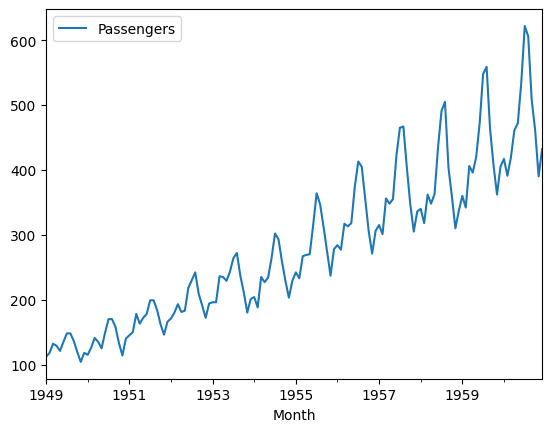

In [51]:
df.plot()
plt.show()


# **Graph Explanation:**

This shows the total number of air passengers over time.

We observe an increasing trend with seasonal variations (yearly pattern).

Since the data has an increasing trend, we might need differencing to make it stationary.

# **Step 4: Checking for Stationarity**

To apply ARIMA, the data must be stationary. We use the Augmented Dickey-Fuller (ADF) test:

In [68]:
def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis, data is stationary.")
    else:
        print("Weak evidence against null hypothesis, data is non-stationary.")

adfuller_test(df['Passengers'])


ADF Test Statistic : 0.8153688792060498
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
Weak evidence against null hypothesis, data is non-stationary.


# **Output Analysis:**
**ADF Test Statistic: 0.81, p-value: 0.99 →** Data is non-stationary.

Since a time series model requires **stationary data**, we apply differencing.

# **Step 5: Making the Data Stationary**

If a trend exists, apply differencing.
If seasonality exists, use Seasonal Differencing (SARIMA instead of ARIMA).

In [69]:
df['Passengers First Difference'] = df['Passengers'] - df['Passengers'].shift(1)
adfuller_test(df['Passengers First Difference'].dropna())

df['Seasonal First Difference'] = df['Passengers'] - df['Passengers'].shift(12)
adfuller_test(df['Seasonal First Difference'].dropna())


ADF Test Statistic : -2.8292668241700047
p-value : 0.05421329028382478
#Lags Used : 12
Number of Observations Used : 130
Weak evidence against null hypothesis, data is non-stationary.
ADF Test Statistic : -3.383020726492481
p-value : 0.011551493085514952
#Lags Used : 1
Number of Observations Used : 130
Strong evidence against null hypothesis, data is stationary.


# **Explanation:**
First Difference: Removes trend but retains seasonality.

**Seasonal Difference (lag=12):** Removes seasonality.

After Seasonal Differencing, the p-value < 0.05, meaning the data is **now stationary.**

# **Step 6: ACF and PACF Plots**

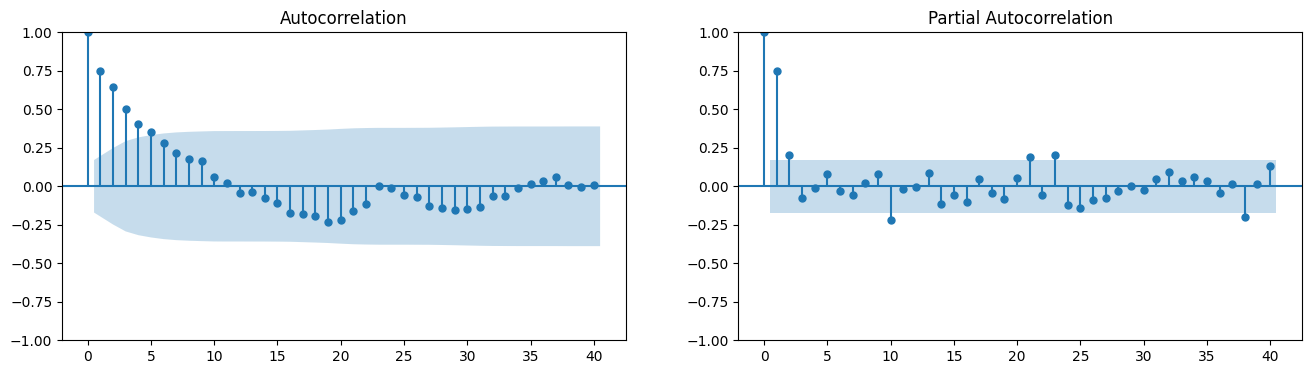

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['Seasonal First Difference'].dropna(), lags=40, ax=axes[0])
plot_pacf(df['Seasonal First Difference'].dropna(), lags=40, ax=axes[1])
plt.show()


# **Graph Explanation:**
ACF (Autocorrelation Function): Identifies MA (q) terms.

PACF (Partial Autocorrelation Function): Identifies AR (p) terms.

Based on the plots, we choose (p=1, d=1, q=1) for ARIMA.

# **Step 7: Fitting ARIMA Model**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Tue, 11 Mar 2025   AIC                           1394.683
Time:                        13:00:08   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

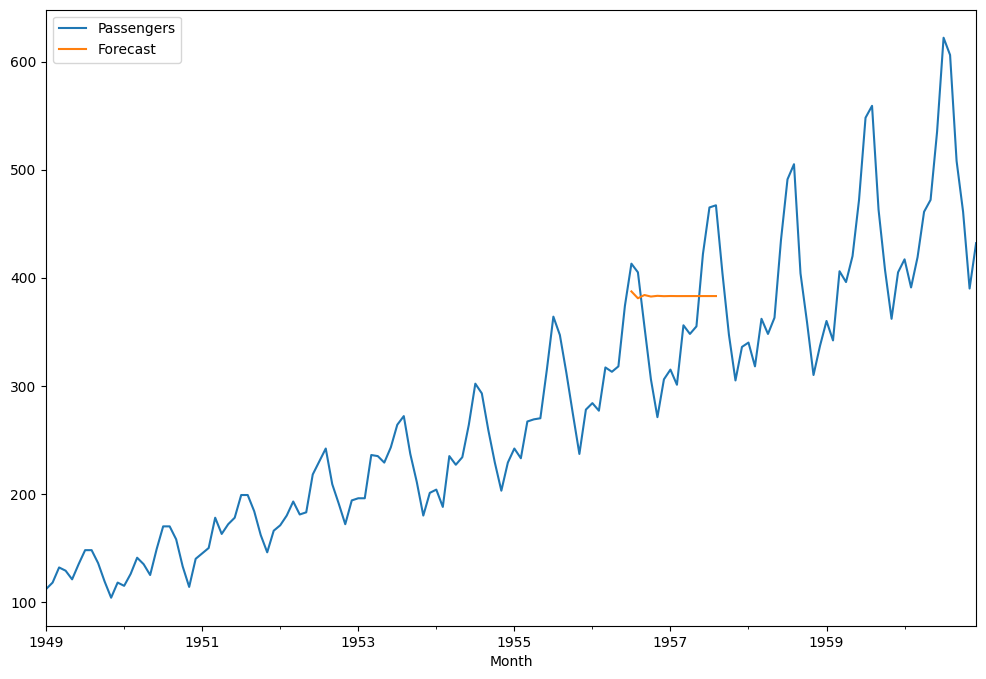

In [71]:
model = ARIMA(df['Passengers'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

df['Forecast'] = model_fit.predict(start=90, end=103, dynamic=True)
df[['Passengers', 'Forecast']].plot(figsize=(12,8))
plt.show()


# **Explanation:**
ARIMA (1,1,1) is fitted to the data.

Predictions are made for future values.

The plot shows how well the model fits the data.

# **Step 8: Fitting Seasonal ARIMA (SARIMA) Model**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


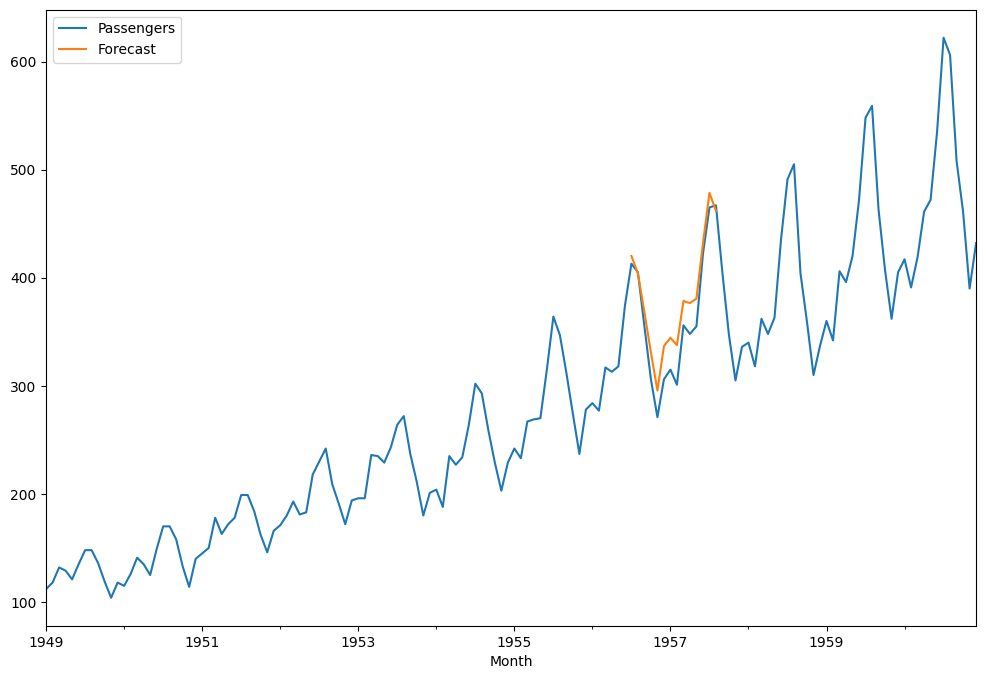

In [72]:
sarima_model = sm.tsa.statespace.SARIMAX(df['Passengers'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()

df['Forecast'] = sarima_results.predict(start=90, end=103, dynamic=True)
df[['Passengers', 'Forecast']].plot(figsize=(12,8))
plt.show()


# **Why SARIMA?**
Since the data has seasonality, SARIMA (Seasonal ARIMA) is a better fit.

SARIMA (1,1,1)(1,1,1,12) accounts for both trend and seasonality.

# **Step 9: Forecasting Future Values**

Now, we forecast the next 10 years (120 months):

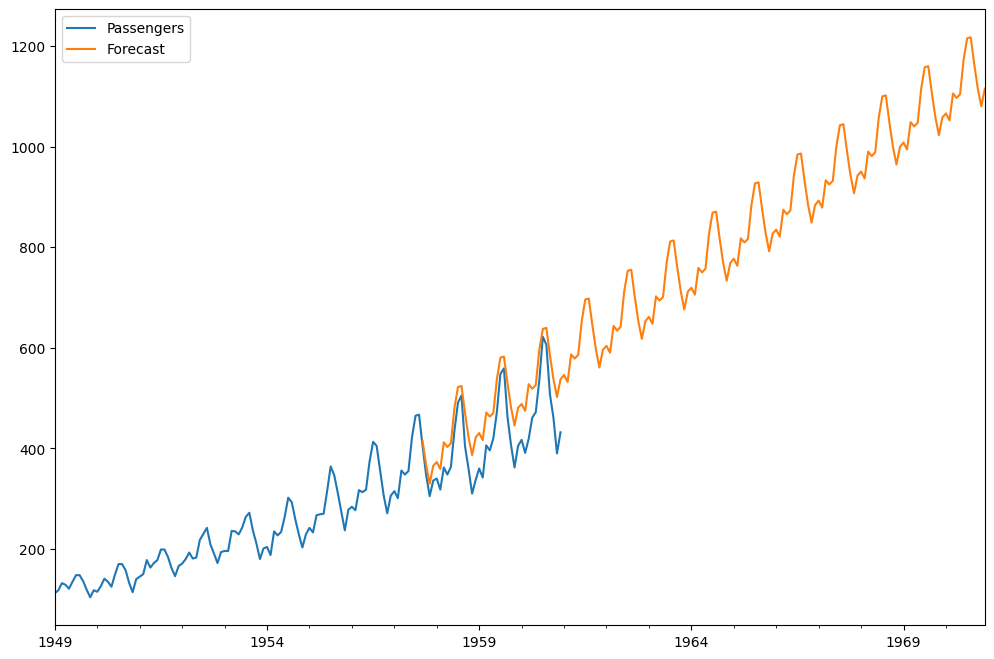

In [78]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 121)]
future_df = pd.DataFrame(index=future_dates, columns=['Passengers'])
future_df = pd.concat([df, future_df])

future_df['Forecast'] = sarima_results.predict(start=104, end=1200, dynamic=True)
future_df[['Passengers', 'Forecast']].plot(figsize=(12,8))
plt.show()

# **Graph Explanation:**
The blue line represents actual data.

The orange line represents future forecast.

The forecast follows the same seasonal trend.

# **Conclusion**

The dataset was non-stationary and required differencing.

Trend and seasonality were identified.

ACF/PACF analysis helped determine the AR & MA terms.

ARIMA was used for non-seasonal forecasting.

SARIMA was used for seasonal forecasting, which provided more accurate predictions.

The final model forecasts future airline passenger numbers for the next 10 years.